In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
data_path = "car_evaluation.csv"
data = np.genfromtxt(data_path, delimiter=",", dtype=str)
labels = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]

In [27]:
print("records: {}".format(len(data)))
print("example record: {}".format(data[0]))
print("\ncolumns:\n")
columns = []
for col in range(len(data[0])):
    print("\t" + labels[col] + ": {}".format(np.unique(data[:,col])))
    columns.append(np.unique(data[:,col]))

records: 1728
example record: ['vhigh' 'vhigh' '2' '2' 'small' 'low' 'unacc']

columns:

	buying: ['high' 'low' 'med' 'vhigh']
	maint: ['high' 'low' 'med' 'vhigh']
	doors: ['2' '3' '4' '5more']
	persons: ['2' '4' 'more']
	lug_boot: ['big' 'med' 'small']
	safety: ['high' 'low' 'med']
	class: ['acc' 'good' 'unacc' 'vgood']


In [18]:
def weighted_entropy(data, col_num):
    entropies = []
    n_s = []
    entropy_of_attribute = entropy(data[:,col_num])
    for value in columns[col_num]:
        candidate_child = data[data[:,col_num] == value]
        n_s.append(len(candidate_child))
        entropies.append(entropy(candidate_child[:,6]))
    n_s = np.array(n_s)
    n_s = n_s / np.sum(n_s)
    weighted_entropy = n_s.dot(entropies)
    return weighted_entropy, entropy_of_attribute
    
def entropy(data):
    classes = np.unique(data)
    n = len(data)
    n_s = []
    for class_ in classes:
        n_s.append(len(data[data==class_]))
    n_s = np.array(n_s)
    n_s = n_s/n
    n_s = n_s * np.log2(n_s)
    return max(0,-np.sum(n_s))

In [28]:
def build_node(data, entropy, label, depth, class_="TBD", parent=None):
    new_node = dict()
    new_node['data'] = data
    new_node['entropy'] = entropy
    new_node['label'] = label
    new_node['depth'] = depth
    new_node['class'] = class_
    new_node['parent'] = parent
    new_node['children'] = []
    return new_node

root = build_node(data, entropy(data[:,6]), "all data", 0)
classes = np.unique(root['data'][:,6])
print(classes)

['acc' 'good' 'unacc' 'vgood']


In [20]:
def find_best_split(node, c45 = False):
    data = node['data']
    entropy = node['entropy']
    gains = []
    for col_num in range(len(columns) - 1):
        new_entropy, entropy_of_attribute = weighted_entropy(data, col_num)
        if c45:
            if entropy_of_attribute==0:
                gains.append(0)
            else:
                gains.append((entropy - new_entropy) / (entropy_of_attribute))
        else:
            gains.append(entropy - new_entropy)
    if np.max(gains) > 10**-3 :
        best_attribute = np.argmax(gains)
        return best_attribute
    else:
        return -1
    
def classify(node_data):
    data = node_data[:, 6]
    n_s = []
    for class_ in classes:
        n_s.append(len(data[data==class_]))
    return columns[-1][np.argmax(n_s)]
    
labels[find_best_split(root)], classify(root['data'])

('safety', 'unacc')

In [21]:
def build_tree(node, c45 = False, max_depth = 999, noisy=False):
    next_split_attribute = find_best_split(node, c45)
    if next_split_attribute == -1 or node['depth'] == max_depth:
        node['class'] = classify(node['data'])
        if noisy:
            label = []
            label.append(node['label'])
            temp_parent = node
            while temp_parent['parent']:
                temp_parent = temp_parent['parent']
                label.append(temp_parent['label'])
            depth = node['depth']
            for i, layer_label in enumerate(reversed(label)):
                for _ in range(i):
                    print("\t", end="")
                if i==depth:
                    print("{} -> class {}".format(layer_label, node['class']))
                else:
                    print("{}".format(layer_label))
                    
    else:
        for value in columns[next_split_attribute]:
            data = node['data'][ node['data'][:, next_split_attribute] == value ]
            entropy_ = entropy(data[:, 6])
            new_node = build_node(data, entropy_, "{} == {}".format(
                                            labels[next_split_attribute],value),
                                            node['depth'] + 1, parent=node)
            build_tree(new_node, c45, max_depth, noisy)
            node['children'].append(new_node)

In [22]:
def correct(decision_tree):
    if not decision_tree['children']:
        return np.sum(classify(decision_tree['data'])==decision_tree['data'][:,6])
    else:
        n_correct = 0
        for child in decision_tree['children']:
            n_correct += correct(child)
    return n_correct

correct(root)/1728

0.7002314814814815

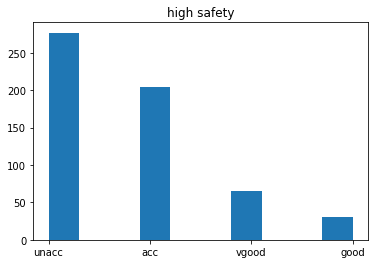

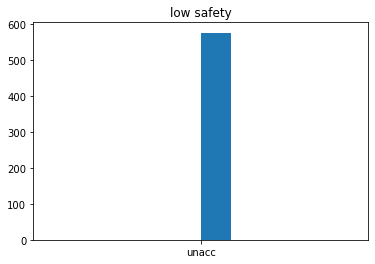

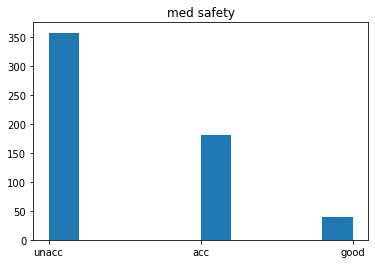

In [30]:
for safety in columns[5]:
    plt.hist(data[data[:,5]==safety, 6])
    plt.title(safety + " safety")
    plt.show()

In [24]:
root = build_node(data, entropy(data[:,6]), "all data", 0)
build_tree(root, max_depth=1,  noisy=True)
print("\nTree Accuracy: {}".format(correct(root)/1728))

all data
	safety == high -> class unacc
all data
	safety == low -> class unacc
all data
	safety == med -> class unacc

Tree Accuracy: 0.7002314814814815


In [25]:
root = build_node(data, entropy(data[:,6]), "all data", 0)
build_tree(root, max_depth=2,  noisy=True)
print("\nTree Accuracy: {}".format(correct(root)/1728))

all data
	safety == high
		persons == 2 -> class unacc
all data
	safety == high
		persons == 4 -> class acc
all data
	safety == high
		persons == more -> class acc
all data
	safety == low -> class unacc
all data
	safety == med
		persons == 2 -> class unacc
all data
	safety == med
		persons == 4 -> class acc
all data
	safety == med
		persons == more -> class acc

Tree Accuracy: 0.7777777777777778


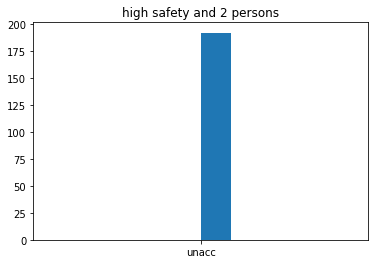

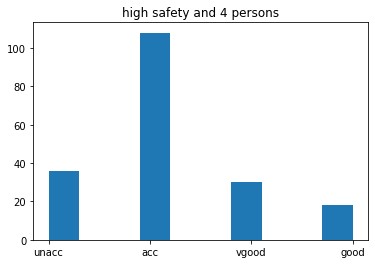

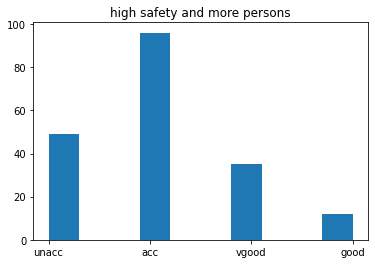

In [26]:
for persons in columns[3]:
    indices1 = data[:,5]=="high"
    indices2 = data[:,3]==persons
    indices = np.alltrue([indices1,indices2], axis=0)
    plt.hist(data[indices, 6])
    plt.title("high safety and {} persons".format(persons))
    plt.show()

In [31]:
print("Training Accuracy Comparison")
print("---------")
print(" ID3    C4.5")
for depth in range(7):
    root = build_node(data, entropy(data[:,6]), "all data", 0)
    build_tree(root, max_depth=depth, c45=False)
    id3=correct(root)/1728
    root = build_node(data, entropy(data[:,6]), "all data", 0)
    build_tree(root, max_depth=depth, c45=True)
    c45=correct(root)/1728
    print('{:.3f} '.format(round(id3,3)), ' {:.3f}'.format(round(c45,3)))

Training Accuracy Comparison
---------
 ID3    C4.5
0.700   0.700
0.700   0.700
0.778   0.778
0.819   0.824
0.899   0.894
0.964   0.964
1.000   1.000
